In [4]:
import pandas as pd
import duckdb

In [5]:
conn: duckdb.DuckDBPyConnection = duckdb.connect("paveai.duckdb")

## 1. SQL Analytics Queries 

### Top 10 most common damage types by vehicle make

In [ ]:

conn.execute("""
SELECT 
    make,
    severity,
    COUNT(*) AS damage_count
FROM 
    sliver.fact_inspections
WHERE
    severity <> 'Unknow' -- We fill NULL value by 'Unknow'
GROUP BY 
    make,
    severity
ORDER BY 
    damage_count DESC
LIMIT 10;

""").fetch_df()

,make,severity,damage_count
0,Jeep,Glass Damage,92
1,Ram,Rust,83
2,Mercedes-Benz,Bumper Damage,82
3,Jeep,Scratch,82
4,Honda,Rust,79
5,Ram,Crack,79
6,Volkswagen,Paint Damage,78
7,Ram,Structural Damage,77
8,Ram,Bumper Damage,77
9,Mazda,Crack,75


### Inspector efficiency metrics (inspections/day, accuracy rates)

In [ ]:
conn.execute("""
WITH all_inspections AS (
    SELECT COUNT(DISTINCT inspection_id) as all_inspections FROM  sliver.fact_inspections
),
total_inspection_stats AS (
    SELECT
        inspector_id,
        COUNT(DISTINCT inspection_id) AS total_inspections,
        SUM(duration_minutes) AS total_duration_minutes,
        COUNT(DISTINCT inspection_id) / (SELECT all_inspections FROM all_inspections) AS inspection_contributions
    FROM
        sliver.fact_inspections
    GROUP BY
        inspector_id
), 
poor_inspection_stats AS (
    SELECT
        inspector_id,
        COUNT(DISTINCT inspection_id) AS total_poor_inspections,
    FROM
        sliver.fact_inspections
    WHERE
        status = 'failed'
    GROUP BY
        inspector_id
), 
inspections_date AS (
    SELECT f.inspector_id,
        d.month,
        d.year, 
        COUNT(DISTINCT inspection_id) AS total_inspections_per_month
    FROM 
        sliver.dim_dates AS d
    JOIN sliver.fact_inspections AS f
        ON f.inspection_datetime_sk = d.date_int
    GROUP BY
        f.inspector_id,
        d.month,
        d.year
), 
inspections_date_stats AS (
    SELECT 
       *,
        SUM(total_inspections_per_month) OVER(PARTITION BY inspector_id, year)::INT AS total_inspections_per_year
    FROM
        inspections_date
),
inspection_stats_calculation AS (
    SELECT
        total.inspector_id,
        total.total_inspections,
        total.total_duration_minutes,
        total.inspection_contributions,
        poor.total_poor_inspections,
        ROUND(1 - poor.total_poor_inspections / total.total_inspections, 3) AS rate_accuracy,
        date_stats.total_inspections_per_month,
        date_stats.total_inspections_per_year,
        date_stats.month,
        date_stats.year,
        FIRST_VALUE(date_stats.total_inspections_per_month) OVER (
            PARTITION BY total.inspector_id 
            ORDER BY year, month
        ) AS first_inspections_in_month,
        FIRST_VALUE(date_stats.total_inspections_per_month) OVER (
            PARTITION BY total.inspector_id 
            ORDER BY year DESC, month DESC
        ) AS last_inspections_in_month
    FROM
        total_inspection_stats As total
    LEFT JOIN
        poor_inspection_stats AS poor
        ON
            total.inspector_id = poor.inspector_id
    JOIN
        inspections_date_stats AS date_stats
        ON
            total.inspector_id = date_stats.inspector_id
)
SELECT
    inspector_id,
    total_inspections,
    total_duration_minutes,
    inspection_contributions AS inspection_contributions_rate,
    total_poor_inspections,
    rate_accuracy,
    total_inspections_per_month,
    total_inspections_per_year,
    month,
    year,
    CASE
        WHEN
            first_inspections_in_month IS NULL OR first_inspections_in_month = 0
        THEN
            NULL
    ELSE
        (last_inspections_in_month / first_inspections_in_month) - 1
    END AS inspection_growth_rate_monthly
FROM
    inspection_stats_calculation
ORDER BY
    inspector_id,
    year,
    month
""").fetch_df()

,inspector_id,total_inspections,total_duration_minutes,inspection_contributions_rate,total_poor_inspections,rate_accuracy,total_inspections_per_month,total_inspections_per_year,month,year,inspection_growth_rate_monthly
0,INS0001,87,5394.0,0.0174,14,0.839,3,18,7,2023,0.333333
1,INS0001,87,5394.0,0.0174,14,0.839,3,18,8,2023,0.333333
2,INS0001,87,5394.0,0.0174,14,0.839,5,18,9,2023,0.333333
3,INS0001,87,5394.0,0.0174,14,0.839,2,18,10,2023,0.333333
4,INS0001,87,5394.0,0.0174,14,0.839,1,18,11,2023,0.333333
...,...,...,...,...,...,...,...,...,...,...,...
1219,INS0050,104,6641.0,0.0208,8,0.923,4,34,3,2025,2.000000
1220,INS0050,104,6641.0,0.0208,8,0.923,9,34,4,2025,2.000000
1221,INS0050,104,6641.0,0.0208,8,0.923,4,34,5,2025,2.000000
1222,INS0050,104,6641.0,0.0208,8,0.923,2,34,6,2025,2.000000


###  Monthly Trending of Inspection Volumes and Damage Costs

In [19]:
conn.execute("""
WITH min_max_inspection_datetime_sk AS (
    SELECT MIN(inspection_datetime_sk) AS min_inspection_datetime_sk, MAX(inspection_datetime_sk) AS max_inspection_datetime_sk  FROM sliver.fact_inspections
)
SELECT 
    d.year,
    d.month,
    COUNT(DISTINCT fi.inspection_id) AS inspection_count,
    SUM(estimated_cost) AS total_damage_cost
FROM
    sliver.dim_dates AS d
LEFT JOIN
    sliver.fact_inspections AS fi
    ON
        d.date_int = fi.inspection_datetime_sk
WHERE
    -- make sure only show in inspection_datetime range
    date_int >= (SELECT min_inspection_datetime_sk FROM min_max_inspection_datetime_sk) 
    AND date_int <= (SELECT max_inspection_datetime_sk FROM min_max_inspection_datetime_sk)
GROUP BY
    d.year,
    d.month
ORDER BY
    d.year,
    d.month

""").fetch_df()

,year,month,inspection_count,total_damage_cost
0,2023,7,89,361208.51
1,2023,8,215,908146.94
2,2023,9,204,837612.28
3,2023,10,182,790026.37
4,2023,11,198,796528.41
5,2023,12,222,914498.56
6,2024,1,193,805492.21
7,2024,2,210,832762.40
8,2024,3,200,859304.59
9,2024,4,202,854362.05


### Geographic Heatmap Data for Damage Severity

In [11]:
conn.execute("""
SELECT 
    lat,
    lon,
    severity,
    COUNT(*) AS total_damage_reports
FROM 
    sliver.fact_inspections fi
GROUP BY 
    lat, lon, severity
ORDER BY 
    total_damage_reports DESC;

""").fetch_df()

,lat,lon,severity,total_damage_reports
0,32.814003,-96.751612,Dent,4
1,40.738472,-74.153982,Glass Damage,3
2,33.634918,-112.020164,Crack,3
3,32.824896,-117.283949,Structural Damage,3
4,34.028723,-118.259836,Paint Damage,3
...,...,...,...,...
8208,42.045372,-87.447670,Unknow,1
8209,32.753985,-117.220597,Unknow,1
8210,37.237659,-121.891793,Unknow,1
8211,40.896780,-74.021497,Unknow,1


In [12]:
# we can pivot the severity value to column

conn.execute("""
SELECT 
    lat,
    lon,
    COUNT(*) FILTER (WHERE severity = 'Crack') AS crack,
    COUNT(*) FILTER (WHERE severity = 'Bumper Damage') AS bumper_damage,
    COUNT(*) FILTER (WHERE severity = 'Dent') AS dent,
    COUNT(*) FILTER (WHERE severity = 'Paint Damage') AS paint_damage,
    COUNT(*) FILTER (WHERE severity = 'Rust') AS rust,
    COUNT(*) FILTER (WHERE severity = 'Glass Damage') AS glass_damage,
    COUNT(*) FILTER (WHERE severity = 'Structural Damage') AS structural_damage,
    COUNT(*) FILTER (WHERE severity = 'Scratch') AS scratch,
    COUNT(*) FILTER (WHERE severity = 'Unknow') AS unknow_damage,
    COUNT(*) AS total_damage_reports
FROM 
    sliver.fact_inspections fi
GROUP BY 
    lat, 
    lon, 
    severity
ORDER BY 
    total_damage_reports DESC;

""").fetch_df()

,lat,lon,crack,bumper_damage,dent,paint_damage,rust,glass_damage,structural_damage,scratch,unknow_damage,total_damage_reports
0,32.814003,-96.751612,0,0,4,0,0,0,0,0,0,4
1,32.767406,-117.020619,0,0,0,0,3,0,0,0,0,3
2,32.745822,-96.703843,0,0,0,0,3,0,0,0,0,3
3,41.956737,-87.438808,0,3,0,0,0,0,0,0,0,3
4,40.717050,-74.019234,0,0,0,0,0,0,3,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
8208,29.659950,-95.632869,0,0,0,0,0,0,0,0,1,1
8209,33.551795,-112.132873,0,0,0,0,0,0,0,0,1,1
8210,32.867872,-117.129792,0,0,0,0,0,0,0,0,1,1
8211,41.872474,-87.648023,0,0,0,0,0,0,0,0,1,1


### Save to golden layer

For visualization

In [5]:
conn.execute("""
CREATE OR REPLACE VIEW golden.v_inspector_analysis AS
WITH all_inspections AS (
    SELECT COUNT(DISTINCT inspection_id) as all_inspections FROM  sliver.fact_inspections
),
total_inspection_stats AS (
    SELECT
        inspector_id,
        COUNT(DISTINCT inspection_id) AS total_inspections,
        SUM(duration_minutes) AS total_duration_minutes,
        COUNT(DISTINCT inspection_id) / (SELECT all_inspections FROM all_inspections) AS inspection_contributions
    FROM
        sliver.fact_inspections
    GROUP BY
        inspector_id
), 
poor_inspection_stats AS (
    SELECT
        inspector_id,
        COUNT(DISTINCT inspection_id) AS total_poor_inspections,
    FROM
        sliver.fact_inspections
    WHERE
        status = 'failed'
    GROUP BY
        inspector_id
), 
inspections_date AS (
    SELECT f.inspector_id,
        d.month,
        d.year, 
        COUNT(DISTINCT inspection_id) AS total_inspections_per_month
    FROM 
        sliver.dim_dates AS d
    JOIN sliver.fact_inspections AS f
        ON f.inspection_datetime_sk = d.date_int
    GROUP BY
        f.inspector_id,
        d.month,
        d.year
), 
inspections_date_stats AS (
    SELECT 
       *,
        SUM(total_inspections_per_month) OVER(PARTITION BY inspector_id, year)::INT AS total_inspections_per_year
    FROM
        inspections_date
),
inspection_stats_calculation AS (
    SELECT
        total.inspector_id,
        total.total_inspections,
        total.total_duration_minutes,
        total.inspection_contributions,
        poor.total_poor_inspections,
        ROUND(1 - poor.total_poor_inspections / total.total_inspections, 3) AS rate_accuracy,
        date_stats.total_inspections_per_month,
        date_stats.total_inspections_per_year,
        date_stats.month,
        date_stats.year,
        FIRST_VALUE(date_stats.total_inspections_per_month) OVER (
            PARTITION BY total.inspector_id 
            ORDER BY year, month
        ) AS first_inspections_in_month,
        FIRST_VALUE(date_stats.total_inspections_per_month) OVER (
            PARTITION BY total.inspector_id 
            ORDER BY year DESC, month DESC
        ) AS last_inspections_in_month
    FROM
        total_inspection_stats As total
    LEFT JOIN
        poor_inspection_stats AS poor
        ON
            total.inspector_id = poor.inspector_id
    JOIN
        inspections_date_stats AS date_stats
        ON
            total.inspector_id = date_stats.inspector_id
)
SELECT
    inspector_id,
    total_inspections,
    total_duration_minutes,
    inspection_contributions AS inspection_contributions_rate,
    total_poor_inspections,
    rate_accuracy,
    total_inspections_per_month,
    total_inspections_per_year,
    month,
    year,
    CASE
        WHEN
            first_inspections_in_month IS NULL OR first_inspections_in_month = 0
        THEN
            NULL
    ELSE
        (last_inspections_in_month / first_inspections_in_month) - 1
    END AS inspection_growth_rate_monthly
FROM
    inspection_stats_calculation
ORDER BY
    inspector_id,
    year,
    month
""")

## 2. QuickSight Dashboard Mock-up

I prepare the PowerBI Desktop file in this repo

In PowerBI I design the Data model with:

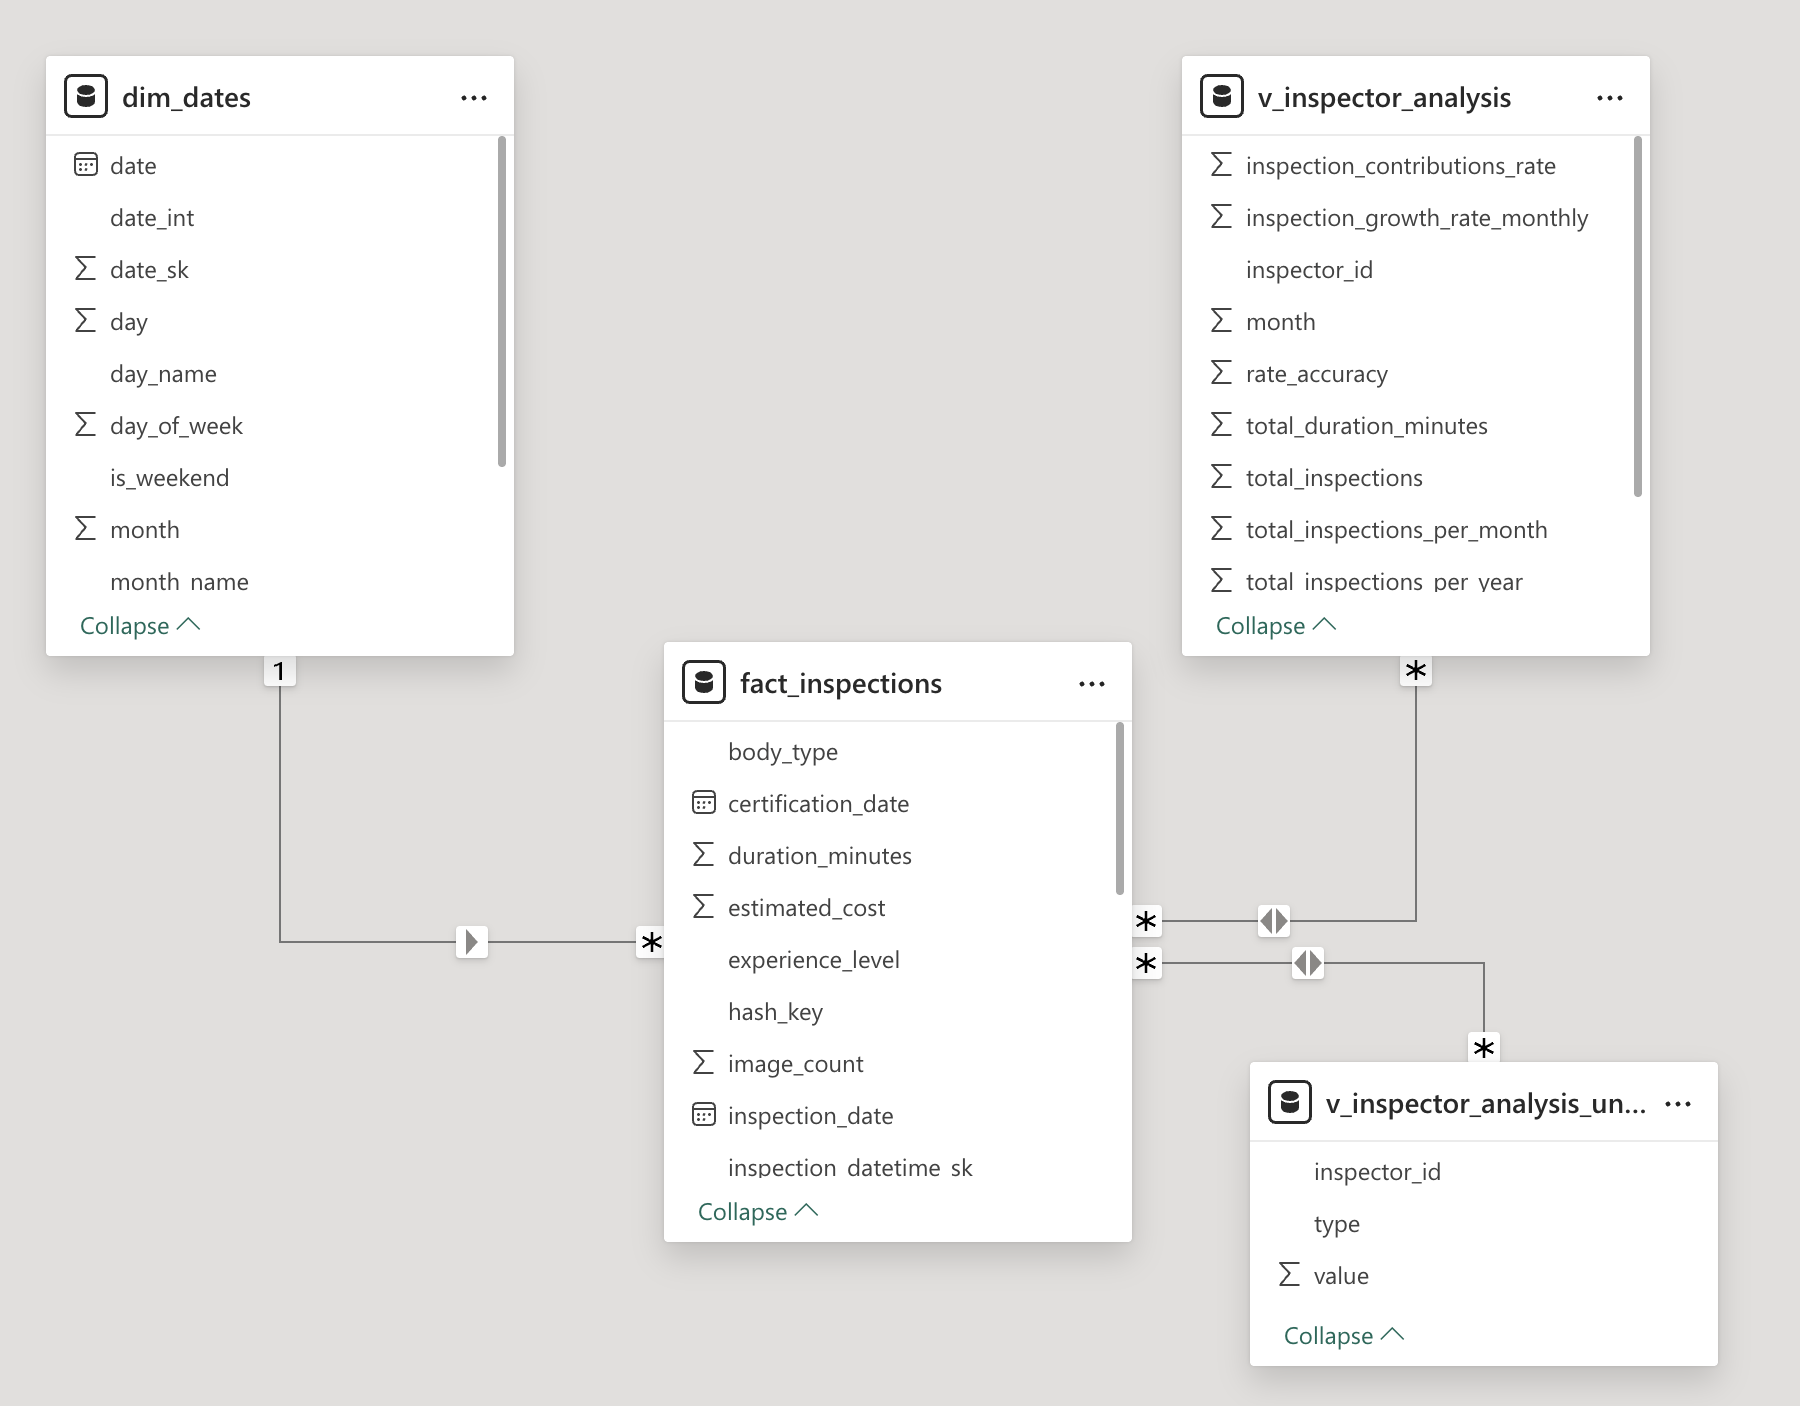


The reason I need to attach view in PowerBI because some calculation is complicated (hard to build by DAX in PowerBI) or I want the calcuation cost was completed by DWH not by PowerBI.

## 3. Real-time Monitoring Queries


### Live inspection count (last hour)

In [ ]:
conn.execute("""
SELECT
    *
FROM 
    sliver.fact_inspections
WHERE 
    inspection_date::TIMESTAMP >= NOW() - INTERVAL '1 hour';

""").fetch_df()

,inspection_id,report_id,vehicle_vin,inspector_id,name,region,experience_level,certification_date,inspections_completed,inspection_date,...,estimated_cost,part_affected,image_count,severity,make,model,vehicle_year,body_type,market_value,hash_key


###  Queue Depth by Region
Assuming:

Queue = inspections in progress or not completed ('pending', 'in_progress')

In [14]:
conn.execute("""
SELECT
    region,
    COUNT(*) AS queue_depth
FROM 
    sliver.fact_inspections
WHERE 
    status IN ('pending', 'in_progress')
GROUP BY 
    region
ORDER BY 
    queue_depth DESC;
""").fetch_df()

,region,queue_depth
0,West,65
1,East,50
2,Central,49
3,South,48
4,North,18


### Failed Inspection Alerts

Assuming “failed” when status = 'failed'

In [17]:
conn.execute("""
SELECT
    inspection_id,
    inspector_id,
    status,
    severity,
    inspection_date
FROM 
    sliver.fact_inspections
WHERE 
    status = 'failed'
ORDER BY 
    inspection_date DESC;
""").fetch_df()

,inspection_id,inspector_id,status,severity,inspection_date
0,INSP003562,INS0048,failed,Unknow,2025-07-16 22:14:15.203895
1,INSP000511,INS0041,failed,Unknow,2025-07-16 14:27:53.309750
2,INSP002196,INS0007,failed,Unknow,2025-07-15 11:42:37.482142
3,INSP003076,INS0012,failed,Unknow,2025-07-15 10:52:33.463070
4,INSP004108,INS0001,failed,Unknow,2025-07-14 15:01:46.310462
...,...,...,...,...,...
508,INSP003102,INS0029,failed,Unknow,2023-07-22 21:23:54.298408
509,INSP003900,INS0019,failed,Unknow,2023-07-19 13:54:26.508475
510,INSP002481,INS0029,failed,Unknow,2023-07-19 04:03:07.704444
511,INSP001873,INS0023,failed,Unknow,2023-07-18 23:45:44.901627
